In [1]:
import os,sys,string, time
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import pickle

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print ('Success')


Success


## Purpose

This notebook was written to look at some truth variables for the in-cryostat $\nu$ sample. However, it is quite a mess of different things now. <br>
I think primarily this can be used to calculat the average true angle of neutrinos in the sample, but nothing else. 

# Loading in the "results" dataframe after full selection

In [2]:
Params = {"Run":"run3", #The run number, so far either "run1" or "run3"
          "Load_lepton_signal":True, #Load ee BDTs
          "Load_pi0_signal":False, #Load pi0 BDTs
          "Use_logit":True} 

Run = Params["Run"] #so far either "run1" or "run3"

if Params["Load_lepton_signal"] == True: HNL_masses = Constants.HNL_mass_samples
if Params["Load_pi0_signal"] == True: HNL_masses = Constants.HNL_mass_pi0_samples

loc_pkl = f'pkl_files/{Run}/current_files/Results/'
if Params["Load_pi0_signal"] == True:loc_pkl+="pi0/"


BDT_name = "_full_Finished_10"
filename = BDT_name

overlay_results = pd.read_pickle(loc_pkl+f"overlay_results{filename}.pkl") #This will contain all of the BDT output scores and rse_id

loc_hists = 'bdt_output/'
if Params["Load_pi0_signal"] == True:loc_hists+="pi0/"

name_type = Functions.Get_signal_name_type(Params)
root_filename = name_type+filename
bins_dict, bin_cents = {}, {}
for HNL_mass in HNL_masses:
    hist_placeholder = uproot.open(loc_hists+f'{Run}_{HNL_mass}_'+root_filename+".root")
    bins_dict[HNL_mass] = hist_placeholder['bkg_overlay'].to_numpy()[1] #A tuple of bin edges
    bin_cents[HNL_mass]=(bins_dict[HNL_mass][:-1]+bins_dict[HNL_mass][1:])/2
    

In [3]:
loc_hists = "Uncertainties/"
if Params["Load_pi0_signal"] == True:loc_hists+="pi0/"

name_type = Functions.Get_signal_name_type(Params)
filename = name_type+'_EXT_full_Finished.root'

frac_ppfx_flat = 0.2
frac_genie_flat = 0.2
frac_reweight_flat = 0.05

for HNL_mass in HNL_masses:
    bins_cent=(bins_dict[HNL_mass][:-1]+bins_dict[HNL_mass][1:])/2
    
    score_hist = np.histogram(Functions.logit(overlay_results[f"BDT_output_{HNL_mass}MeV"]), weights=overlay_results[f"weight"], bins=bins_dict[HNL_mass], 
                              range=[bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]])[0]

    values_dict = {'ppfx_uncertainty': score_hist*frac_ppfx_flat, 'Genie_uncertainty':score_hist*frac_genie_flat,
                   'Reinteraction_uncertainty': score_hist*frac_reweight_flat,
                   'ppfx_uncertainty_frac': np.ones(len(score_hist))*frac_ppfx_flat, 
                   'Genie_uncertainty_frac':np.ones(len(score_hist))*frac_genie_flat,
                   'Reinteraction_uncertainty_frac':np.ones(len(score_hist))*frac_reweight_flat} 
    hist_samples = {}

    #make array with all values 1, then weight by value
    for name in values_dict:
        test_hist = np.histogram(bins_cent, weights=values_dict[name], bins=bins_dict[HNL_mass], 
                                 range=[bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]])
        hist_samples[name] = test_hist

    stop_writing = False
    dont_save = []
    with uproot.open(loc_hists+Params["Run"]+f'_{HNL_mass}_'+filename) as file:
    # with uproot.open(loc_hists+f'{Run}_{HNL_mass}MeV_{filename}.root') as file: #Check what is already in the file (read-only)
        for name in hist_samples:
            if str(name)+";1" in file.keys():
                # print(str(name) + f" ALREADY EXISTS in {HNL_mass}MeV file, not re-saving")
                dont_save.append(name)

    with uproot.update(loc_hists+f'{Run}_{HNL_mass}_{filename}') as file: #Add new hists into the file
        # del file['ppfx_uncertainty']

        for name in hist_samples:
            # if stop_writing == True:
            #     print("Not saving hist")
            #     break
            if name in dont_save:
                # print(f"Not saving {name}")
                continue
            else:
                file[name] = hist_samples[name]
print("Done")

Done


# Reading in the overlay .root file with reweight branches

In [5]:
#nu_pdg, ccnc, npi0
sys_variables = Variables.event_vars + Variables.weight_related + ["nu_pdg", "ccnc", "npi0", "mc_px", "mc_py", "mc_pz"]

if Run == "run1":
    NuMI_MC_overlay = uproot3.open('../NuMI_MC/SLIMMED_neutrinoselection_filt_run1_overlay.root')['nuselection/NeutrinoSelectionFilter']
    Norm = Constants.SF_overlay_run1
elif Run == "run3":
    NuMI_MC_overlay = uproot3.open('../NuMI_MC/SLIMMED_neutrinoselection_filt_run3_overlay.root')['nuselection/NeutrinoSelectionFilter']
    Norm = Constants.SF_overlay_run3

#ADD this when doing properly
df_overlay_weights = NuMI_MC_overlay.pandas.df(sys_variables, flatten=False) #Perhaps I can do this in a more clever way than just making a dataframe


## Calculating average angle from beam events

In [17]:
df_overlay_weights = NuMI_MC_overlay.pandas.df(["shr_theta_v", "shr_phi_v"], flatten=True)

In [18]:
df_overlay_weights.keys()

Index(['shr_theta_v', 'shr_phi_v'], dtype='object')

In [19]:
df_overlay_weights["shr_theta_v"]

entry   subentry
0       0           0.561943
3       0           0.604881
        1           0.367757
4       0           2.195109
        1           0.562130
                      ...   
748696  0           0.470489
748697  0           0.274861
        1           1.378470
748698  0           1.286198
748701  0           0.970317
Name: shr_theta_v, Length: 896321, dtype: float32

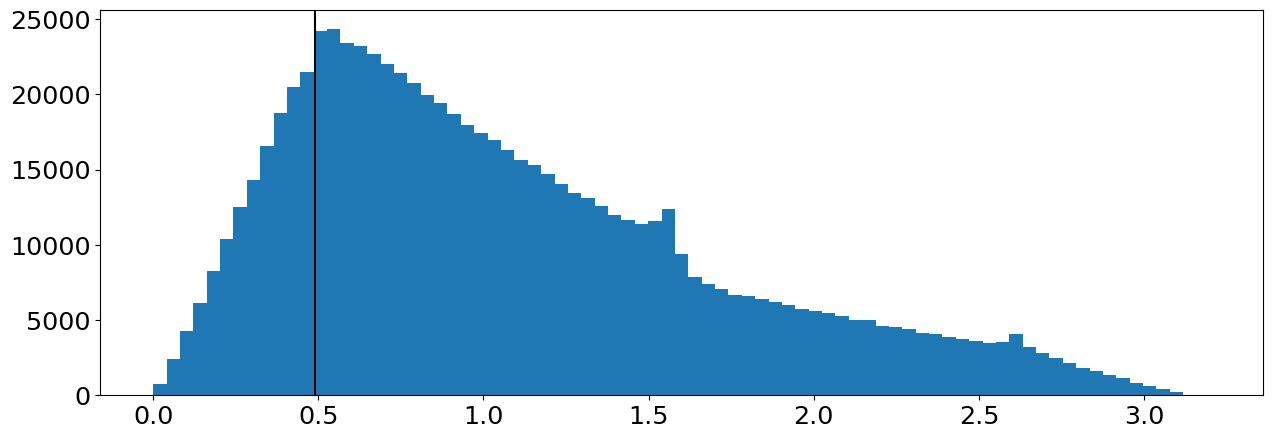

In [25]:
x,y=np.histogram(df_overlay_weights["shr_theta_v"],bins=30,range=[0, 3.2],density=True)
bins_test = np.linspace(0, 3.2, 80)
plt.hist(df_overlay_weights["shr_theta_v"], bins=bins_test )
# x,y=np.histogram(var_Data,bins=bins,range=xlims,density=density)
# plt.xlim([0, 3.2])
plt.axvline(0.49, color="black")

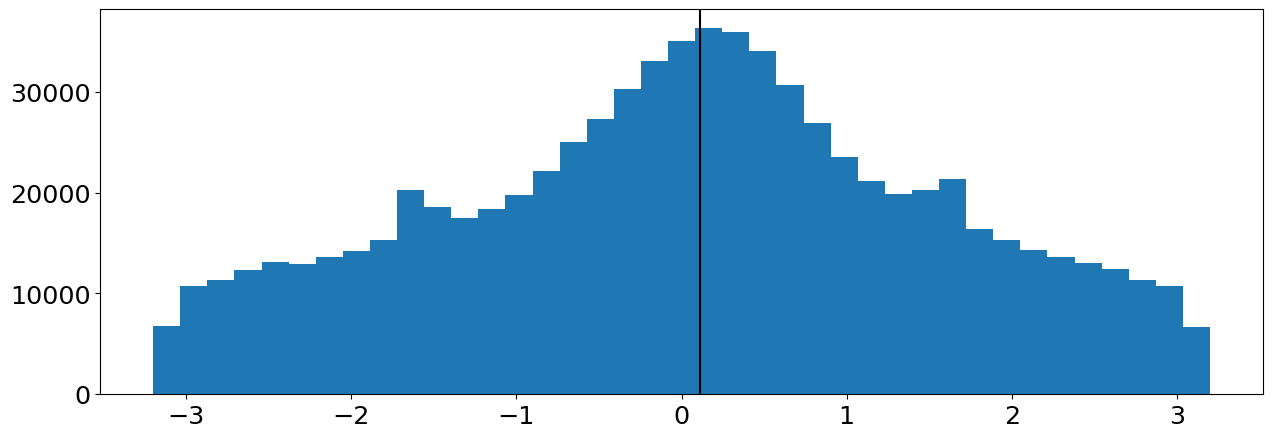

In [26]:
bins_test = np.linspace(-3.2, 3.2, 40)
plt.hist(df_overlay_weights["shr_phi_v"], bins=bins_test )
plt.axvline(0.11, color="black")

In [ ]:
# Get average 
def Get_av_hnl_momentum(df):
    """
    Returns a vector of the mean momenta of the parent HNL
    """
    x_sum = df['mc_px'].sum()
    y_sum = df['mc_py'].sum()
    z_sum = df['mc_pz'].sum()
    
    x_av = x_sum/len(df)
    y_av = y_sum/len(df)
    z_av = z_sum/len(df)
    
    direction = []
    for i in df.index:
        mc_p = np.sqrt(df['mc_px'][i]**2+df['mc_py'][i]**2+df['mc_pz'][i]**2)
        direction.append([df['mc_px'][i]/mc_p, df['mc_py'][i]/mc_p, df['mc_pz'][i]/mc_p])
    
    return [x_av, y_av, z_av], direction

def DF_av_hnl_momentum(df):
    """
    Returns a vector of the mean momenta of the parent HNL
    """
    x_sum = df['mc_px'].sum()
    y_sum = df['mc_py'].sum()
    z_sum = df['mc_pz'].sum()
    
    x_av = x_sum/len(df)
    y_av = y_sum/len(df)
    z_av = z_sum/len(df)
    
    direction = []
    df["theta"]=df['mc_px']
    # for i in df.index:
    #     mc_p = np.sqrt(df['mc_px'][i]**2+df['mc_py'][i]**2+df['mc_pz'][i]**2)
    #     direction.append([df['mc_px'][i]/mc_p, df['mc_py'][i]/mc_p, df['mc_pz'][i]/mc_p])
    
    return [x_av, y_av, z_av], direction


In [ ]:
vector, direction = DF_av_hnl_momentum(df_overlay_weights)

In [ ]:
print(vector)

# Keeping only the events which pass selection in the weight dataframe

In [6]:
def make_unique_ev_id(df): #df must have 'run', 'sub' and 'evt' branches
    if pd.Series(['run', 'sub', 'evt']).isin(df.columns).all():
        rse_list = []
        for entry in df.index: #Looping over all events in the dataframe
            rse = str(df['run'][entry]) + "_" + str(df['sub'][entry]) + "_" + str(df['evt'][entry])
            rse_list.append(rse)
        df['rse_id'] = rse_list #Writing a new branch with the unique event id
        return df.copy()
    else:
        print("Dataframe needs \"run\", \"sub\" and \"evt\" columns.")
        return 0
    
def check_duplicate_events(df):
    rse_list = df['rse_id'].to_list()

    seen = set()
    dupes = []

    for x in rse_list:
        if x in seen:
            dupes.append(x)
        else:
            seen.add(x)
    print("Number of duplicates is " + str(len(dupes)))
    print("Number of unique events is " + str(len(seen)))

overlay_results_rse = make_unique_ev_id(overlay_results)
df_overlay_weights_rse = make_unique_ev_id(df_overlay_weights)

#Deleting any duplicates of events, should be able to avoid if correctly filtered for one event per row
overlay_results_rse.drop_duplicates(subset=['rse_id'], keep='first', inplace=True)

print("Number of events in weights file is " + str(len(df_overlay_weights_rse)))
print("Number of events in results file is " + str(len(overlay_results_rse)))

Number of events in weights file is 748702
Number of events in results file is 14833


In [7]:
#Keeping only those events in the final selection
filtered_weights = df_overlay_weights_rse.loc[(df_overlay_weights_rse['rse_id'].isin(overlay_results_rse['rse_id']))]

print("Number of events in the filtered weights file is " + str(len(filtered_weights)))
print("Number of events in results file is " + str(len(overlay_results_rse)))

Number of events in the filtered weights file is 14833
Number of events in results file is 14833


## Calculating uncertainty for a BDT input variable

In [8]:
print(filtered_weights.keys())
print(overlay_results_rse.keys())

Index(['run', 'sub', 'evt', 'weightSplineTimesTune', 'ppfx_cv', 'npi0',
       'nu_pdg', 'ccnc', 'npi0', 'mc_px', 'mc_py', 'mc_pz', 'rse_id'],
      dtype='object')
Index(['run', 'sub', 'evt', 'weightSplineTimesTune', 'ppfx_cv', 'npi0',
       'weight', 'BDT_output_2MeV', 'BDT_output_10MeV', 'BDT_output_20MeV',
       'BDT_output_50MeV', 'BDT_output_100MeV', 'BDT_output_150MeV', 'rse_id'],
      dtype='object')


In [9]:
BDT_score_list = []

# HNL_masses = [20, 50, 100, 150, 180, 200] #Should get rid of this once made overlay branches with all results

for HNL_mass in HNL_masses:
    BDT_score_list.append(f'BDT_output_{HNL_mass}MeV')

just_score_df = overlay_results_rse[BDT_score_list + ['rse_id','weight']].copy()

final_merged = pd.merge(filtered_weights,just_score_df, how='outer', on=['rse_id'])


In [10]:
final_merged.keys()

Index(['run', 'sub', 'evt', 'weightSplineTimesTune', 'ppfx_cv', 'npi0',
       'nu_pdg', 'ccnc', 'npi0', 'mc_px', 'mc_py', 'mc_pz', 'rse_id',
       'BDT_output_2MeV', 'BDT_output_10MeV', 'BDT_output_20MeV',
       'BDT_output_50MeV', 'BDT_output_100MeV', 'BDT_output_150MeV', 'weight'],
      dtype='object')

In [11]:
HNL_mass = 10
signal_region = 5

var = f'BDT_output_{HNL_mass}MeV'
overlay = final_merged

signal_region_invlogit = Functions.invlogit(signal_region)
print(f"Signal region is above {signal_region_invlogit}")

overlay_signal_region = overlay.query(var+">"+str(signal_region_invlogit))

numu_CC_npi0_ls = '((nu_pdg==14 or nu_pdg==-14) and ccnc==0 and npi0>=1)'
numu_CC_0pi0 = '((nu_pdg==14 or nu_pdg==-14) and ccnc==0 and npi0==0)'
numu_NC_npi0_ls = '((nu_pdg==14 or nu_pdg==-14) and ccnc==1 and npi0>=1)'
numu_NC_0pi0 = '((nu_pdg==14 or nu_pdg==-14) and ccnc==1 and npi0==0)'
nue_ccnc_ls = '(nu_pdg==12 or nu_pdg==-12)'
other = 'nu_pdg != nu_pdg'

NC_pi0_sample = overlay.query(numu_NC_npi0_ls)

# stacked_hist = [Functions.logit(overlay.query(numu_CC_npi0_ls)[var]), #var is the BDT score
#                 Functions.logit(overlay.query(numu_CC_0pi0)[var]),
#                 Functions.logit(overlay.query(numu_NC_npi0_ls)[var]),
#                 Functions.logit(overlay.query(numu_NC_0pi0)[var]),
#                 Functions.logit(overlay.query(nue_ccnc_ls)[var])]
    


Signal region is above 0.9933071490757152


In [12]:
print(NC_pi0_sample["rse_id"])

3          17055_98_4930
8          17048_51_2577
14        16949_107_5370
16       16874_324_16237
20       15799_227_11363
              ...       
14800        14209_4_210
14815        16432_3_198
14816      16432_61_3072
14821        15267_6_322
14822        15267_6_337
Name: rse_id, Length: 1714, dtype: object


In [13]:
print(NC_pi0_sample['nu_pdg'])

3        14
8        14
14       14
16       14
20       14
         ..
14800   -14
14815    14
14816    14
14821   -14
14822   -14
Name: nu_pdg, Length: 1714, dtype: int32


In [18]:
HNL_mass = 10
signal_region = 3.0

var = f'BDT_output_{HNL_mass}MeV'
overlay = final_merged

signal_region_invlogit = Functions.invlogit(signal_region)
print(f"Signal region is above {signal_region_invlogit}")

overlay_signal_region = overlay.query(var+">"+str(signal_region_invlogit))

numu_CC_npi0_ls = '((nu_pdg==14 or nu_pdg==-14) and ccnc==0 and npi0>=1)'
numu_CC_0pi0 = '((nu_pdg==14 or nu_pdg==-14) and ccnc==0 and npi0==0)'
numu_NC_npi0_ls = '((nu_pdg==14 or nu_pdg==-14) and ccnc==1 and npi0>=1)'
numu_NC_0pi0 = '((nu_pdg==14 or nu_pdg==-14) and ccnc==1 and npi0==0)'
nue_ccnc_ls = '(nu_pdg==12 or nu_pdg==-12)'
other = 'nu_pdg != nu_pdg'

NC_pi0_sample_signal_like = overlay_signal_region.query(numu_NC_npi0_ls)

Signal region is above 0.9525741268224333


In [19]:
print(len(NC_pi0_sample_signal_like))

28


In [20]:
import csv

In [21]:
#saving NC pi0 event numbers
csv_location = "bdt_output/signal_like_rse_lists/"
signal_sample = "10_ee"

overlay_run_sub_event = NC_pi0_sample_signal_like[["run", "sub", "evt"]]
csv_overlay_name = csv_location + Params["Run"] + f"_NC_pi0_overlay_{signal_sample}.csv"
overlay_run_sub_event.to_csv(csv_overlay_name, sep=" ", header=False, index=False)

csv_file = csv_overlay_name
txt_file = csv_location + Params["Run"] + f"_NC_pi0_overlay_{signal_sample}.list" #could save this as .txt, just following Owen's naming system so using .list
with open(txt_file, "w") as my_output_file:
    with open(csv_file, "r") as my_input_file:
        [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()
    

## Merging into one dataframe with results and weights

In [ ]:
def make_overflow_bin(bins_dict, bins_cents_dict):
    """
    For making the final "overflow" bin the same size as the previous bins, i.e one integer in width.
    """
    bins_overflow, bins_cent_overflow = {}, {}
    for HNL_mass in bins_dict:
        overflow_bin = bins_cents_dict[HNL_mass][-2]+1 #Just adding one to the penultimate bin centre val. 
        bins_cent_overflow[HNL_mass] = bins_cents_dict[HNL_mass].copy()
        bins_cent_overflow[HNL_mass][-1] = overflow_bin
        bins_overflow[HNL_mass] = bins_dict[HNL_mass].copy()
        bins_overflow[HNL_mass][-1] = bins_dict[HNL_mass][-2]+1 #Just adding one to the penultimate bin end val. 
    return bins_overflow, bins_cent_overflow

bins_overflow, bins_cents_overflow = make_overflow_bin(bins_dict, bin_cents)

def make_xlims_dict(bins_dict, spacing, lower = None):
    """
    Making a dict of xlims for plotting several mass points at once.
    Also returns a dict of xticks for the purpose of indicating the overflow.
    """
    xlims_adjusted, xticks_adjusted = {}, {}
    vals_dict={}
    for HNL_mass in bins_dict:
        if isinstance(lower,(int, float)): lower_val = lower
        else: lower_val = bins_dict[HNL_mass][0]
        xlims_adjusted[HNL_mass] = [lower_val,bins_dict[HNL_mass][-1]]
        ticks = np.arange(bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1], spacing)
        if ticks[-1] != bins_dict[HNL_mass][-2]: ticks = np.append(ticks, bins_dict[HNL_mass][-1]-1)
        ticks_strings = []
        vals = []
        for val in ticks:
            ticks_strings.append(str(int(val)))
            vals.append(val)
        ticks_strings[-1] = str(ticks_strings[-1])+"+"
        xticks_adjusted[HNL_mass] = ticks_strings
        vals_dict[HNL_mass] = vals
        
    return xlims_adjusted, xticks_adjusted, vals_dict

xlims_dict, xticks_dict, vals_dict = make_xlims_dict(bins_overflow, 2)

In [ ]:
print(xticks_dict)

In [ ]:
mass = 150
plt.hist(Functions.logit(final_merged[f'BDT_output_{mass}MeV']),bins=bins_dict[mass])

## Plotting the different overlay contributions

In [ ]:
#Start of Aditya's code
def Plot_overlay_contributions(df, HNL_mass, bins_dict, bins_original, bins_cent_dict, signal_region, xticks=[], vals_dict=[], xlims=[], ylims=[]):
    """
    Given an overlay dataframe with the MC truth information, plots the BDT score with a breakdown of the overlay contributions.
    """
    plt.rcParams.update({'font.size': 28})
    
    plt.figure(figsize=[10,7])
    
    var = f'BDT_output_{HNL_mass}MeV'
    overlay = df
    
    signal_region_invlogit = Functions.invlogit(signal_region)
    print(f"Signal region is above {signal_region_invlogit}")
    print(type(signal_region_invlogit))
    
    overlay_signal_region = overlay.query(var+">"+str(signal_region_invlogit))
    
    numu_CC_npi0_ls = '((nu_pdg==14 or nu_pdg==-14) and ccnc==0 and npi0>=1)'
    numu_CC_0pi0 = '((nu_pdg==14 or nu_pdg==-14) and ccnc==0 and npi0==0)'
    numu_NC_npi0_ls = '((nu_pdg==14 or nu_pdg==-14) and ccnc==1 and npi0>=1)'
    numu_NC_0pi0 = '((nu_pdg==14 or nu_pdg==-14) and ccnc==1 and npi0==0)'
    nue_ccnc_ls = '(nu_pdg==12 or nu_pdg==-12)'
    other = 'nu_pdg != nu_pdg'
    
    
    stacked_hist = [Functions.logit(overlay.query(numu_CC_npi0_ls)[var]), #var is the BDT score
                    Functions.logit(overlay.query(numu_CC_0pi0)[var]),
                    Functions.logit(overlay.query(numu_NC_npi0_ls)[var]),
                    Functions.logit(overlay.query(numu_NC_0pi0)[var]),
                    Functions.logit(overlay.query(nue_ccnc_ls)[var])]
    
    WEIGHTS = [overlay.query(numu_CC_npi0_ls)["weight"],
               overlay.query(numu_CC_0pi0)["weight"],
               overlay.query(numu_NC_npi0_ls)["weight"],
               overlay.query(numu_NC_0pi0)["weight"],
               overlay.query(nue_ccnc_ls)["weight"]]
    
    weights_signal_region = [overlay_signal_region.query(numu_CC_npi0_ls)["weight"],
                             overlay_signal_region.query(numu_CC_0pi0)["weight"],
                             overlay_signal_region.query(numu_NC_npi0_ls)["weight"],
                             overlay_signal_region.query(numu_NC_0pi0)["weight"],
                             overlay_signal_region.query(nue_ccnc_ls)["weight"]]
    
    Total_overlay_weights = sum(overlay["weight"])
    Total_signal_region_weights = sum(overlay_signal_region["weight"])
    print(f"Total overlay weights is {Total_overlay_weights}")
    sum_weights = []
    signal_weights = []
    Total_weights = 0
    for i, weights in enumerate(WEIGHTS):
        sum_weights.append(sum(weights))
        signal_weights.append(sum(weights_signal_region[i]))
        Total_weights += sum(weights)
        
    print(f"Total contribution weights is {Total_weights}")
    fractions_each = []
    frac_signal = []
    for i, weights in enumerate(sum_weights):
        frac = weights/Total_weights
        frac_region = signal_weights[i]/Total_signal_region_weights
        fractions_each.append(frac)
        frac_signal.append(frac_region)
    
    COLOR = ['steelblue','palegreen','green','y','olive']
    
    varis=stacked_hist
    weights=WEIGHTS
    colors=COLOR
    labels=[r"$\nu_{\mu}$ CC $n\pi^{0}$", r"$\nu_{\mu}$ CC $0\pi^{0}$", r"$\nu_{\mu}$ NC $n\pi^{0}$", r"$\nu_{\mu}$ NC $0\pi^{0}$", r"$\nu_{e}$"] 
    
    for i, label in enumerate(labels):
        print(f"{label} fraction is " + str(fractions_each[i]))
        
    for i, label in enumerate(labels):
        print(f"{label} fraction in signal region is " + str(frac_signal[i]))
        
    
    all_vals = []
    bins_cents = []
    for i, label in enumerate(labels):
        all_vals.append(np.histogram(stacked_hist[i], weights=WEIGHTS[i], bins=bins_original[HNL_mass])[0])
        bins_cents.append(bins_cent_dict[HNL_mass])

    # plot=plt.hist(varis,
    #               bins=bins_dict[HNL_mass],
    #               label=labels,
    #               histtype="stepfilled",
    #               stacked=True,density=True,linewidth=2,edgecolor="darkblue",
    #               weights=weights, color=colors)
    
    plot=plt.hist(bins_cents,
                  bins=bins_dict[HNL_mass],
                  label=labels,
                  histtype="stepfilled",
                  stacked=True,density=True,linewidth=2,edgecolor="black",
                  weights=all_vals, color=colors)
    
    if isinstance(xticks,dict):
        plt.xticks(ticks=vals_dict[HNL_mass], labels=xticks[HNL_mass])
    
    if xlims!=[]:
        plt.xlim(xlims)
        
    if ylims!=[]:
        plt.ylim(ylims)
    
    plt.legend(fontsize=20)
    
    plt.xlabel(f'BDT Score '+r'($m_{\mathrm{HNL}}=$'+f'{HNL_mass} MeV)', fontsize=30)
    plt.ylabel("Fraction of events", fontsize=30)
    
    plt.tight_layout()
    

In [ ]:
if Params["Load_lepton_signal"] == True: HNL_mass = 100
if Params["Load_pi0_signal"] == True: HNL_mass = 200

if Params["Load_lepton_signal"] == True: decay_type = "ee"
if Params["Load_pi0_signal"] == True: decay_type = "pi0"

Plot_overlay_contributions(final_merged, HNL_mass, bins_overflow, bins_dict, bins_cents_overflow, signal_region = 3, 
                           xticks=xticks_dict, vals_dict=vals_dict, 
                           xlims=[3, 6], ylims=[0, 0.004])
save_fig = input("Do you want to save the new BDT scores to .pkl files? y/n ")
if save_fig == "y":
    plt.savefig(f"plots/BDT_output/overlay_composition/overlay_score_breakdown_signal_region_{HNL_mass}_{decay_type}_model.pdf")
    plt.savefig(f"plots/BDT_output/overlay_composition/overlay_score_breakdown_signal_region_{HNL_mass}_{decay_type}_model.png")

In [ ]:
Plot_overlay_contributions(final_merged, HNL_mass, bins_overflow, bins_dict, bins_cents_overflow, signal_region = 3, 
                           xticks=xticks_dict, vals_dict=vals_dict, 
                           xlims=[], ylims=[])
save_fig = input("Do you want to save the new BDT scores to .pkl files? y/n ")
if save_fig == "y":
    plt.savefig(f"plots/BDT_output/overlay_composition/overlay_score_breakdown_full_dist_{HNL_mass}_{decay_type}_model.pdf")
    plt.savefig(f"plots/BDT_output/overlay_composition/overlay_score_breakdown_full_dist_{HNL_mass}_{decay_type}_model.png")
    

# Plotting the BDT score with all different multisims

In [ ]:
def All_reweight_err(df, var_name, BINS, x_range, logit=True):
    results_dict = {}
    n_bins = len(BINS)-1
    for Multisim in Constants.Multisim_univs:
        Nuniverse = Constants.Multisim_univs[Multisim]
        n_tot = np.empty([Nuniverse, n_bins])
        n_cv_tot = np.empty(n_bins)
        n_tot.fill(0)
        n_cv_tot.fill(0)
        
        if logit == True:
            variable = Functions.logit(df[var_name]) #The BDT output score
        else:
            variable = df[var_name] #The BDT output score
        syst_weights = df[Multisim] #An array of length of the number of events, each entry is an array of length Nunivs
        spline_fix_cv  = df["weight"]#*Norm #This needs to be normalized by the POT scaling for correct values
        spline_fix_var = df["weight"]#*Norm
        
        s = syst_weights
        df_weights = pd.DataFrame(s.values.tolist())
        n_cv, bins = np.histogram(variable, range=x_range, bins=BINS, weights=spline_fix_cv)
        n_cv_tot += n_cv
        
        if(Multisim == "weightsGenie"): #special treatment as ["weightSplineTimesTune"] is included in genie weights
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[weight == 1]= df["weightSplineTimesTune"].iloc[weight == 1]
                    weight[np.isnan(weight)] = df["weightSplineTimesTune"].iloc[np.isnan(weight)]
                    weight[weight > 50] = df["weightSplineTimesTune"].iloc[weight > 50] # why 30 not 50?
                    weight[weight <= 0] = df["weightSplineTimesTune"].iloc[weight <= 0]
                    weight[weight == np.inf] = df["weightSplineTimesTune"].iloc[weight == np.inf]
                
                    n, bins = np.histogram(variable, 
                                           weights=np.nan_to_num(weight*spline_fix_var/df["weightSplineTimesTune"]), range=x_range, bins=BINS)
                    n_tot[i] += n
                    
        if(Multisim == "weightsPPFX"): #special treatment as ["PPFXPcv"] is included in ppfx weights
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[weight == 1]= df["ppfx_cv"].iloc[weight == 1]
                    weight[np.isnan(weight)] = df["ppfx_cv"].iloc[np.isnan(weight)]
                    weight[weight > 100] = df["ppfx_cv"].iloc[weight > 100]
                    weight[weight < 0] = df["ppfx_cv"].iloc[weight < 0]
                    weight[weight == np.inf] = df["ppfx_cv"].iloc[weight == np.inf]
                
                    n, bins = np.histogram(variable, weights=weight*np.nan_to_num(spline_fix_var/df["ppfx_cv"]), range=x_range, bins=BINS)
                    n_tot[i] += n
        
        if(Multisim == "weightsReint"):
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[np.isnan(weight)] = 1
                    weight[weight > 100] = 1
                    weight[weight < 0] = 1
                    weight[weight == np.inf] = 1
                    n, bins = np.histogram(variable, weights=weight*spline_fix_var, range=x_range, bins=BINS)
                    n_tot[i] += n
        cov = np.empty([len(n_cv), len(n_cv)])
        cov.fill(0)

        for n in n_tot:
            for i in range(len(n_cv)):
                for j in range(len(n_cv)):
                    cov[i][j] += (n[i] - n_cv_tot[i]) * (n[j] - n_cv_tot[j])

        cov /= Nuniverse
        results_dict[Multisim] = [cov,n_cv_tot,n_tot,bins]
    return results_dict

In [ ]:
# HNL_mass = 50
logit = True
results_dict = {}
for HNL_mass in HNL_masses:
    print(f"Calculating {HNL_mass} uncertainties.")
    results_dict[HNL_mass] = All_reweight_err(final_merged, f'BDT_output_{HNL_mass}MeV', bins_dict[HNL_mass],
                                    [bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]], logit=logit)

print("Done!")

In [ ]:
results_dict[HNL_mass].keys()

In [ ]:
def Plot_multisim(results_dict, HNL_mass, bins_dict, bin_cents, xticks_dict, xticks_vals, 
                  savefig=False, display=False, Params={}):
    translate_dict = {'weightsPPFX':"Flux", 'weightsGenie':"Genie", 'weightsReint':"Reinteractions"}
    for Multisim in results_dict:
        Multisim_name = translate_dict[Multisim]
        Nuniverse = Constants.Multisim_univs[Multisim]
        cov = results_dict[Multisim][0]
        cv = results_dict[Multisim][1]
        n_tot = results_dict[Multisim][2]
        # bins = results_dict[Multisim][3]
        bins = bins_dict[HNL_mass]
        xlims = [min(bins), max(bins)]
        
        fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=[10,10],dpi=200)
        plt.sca(ax[0])

        # bins=np.linspace(0,1.0,21)

        # bins_cent=(bins[:-1]+bins[1:])/2
        bins_cent=bin_cents[HNL_mass]
        bins_centlong=np.tile(bins_cent,Nuniverse)

        nybins=70

        plt.title(Multisim_name + " Variations",fontsize=20)

        plt.hist(bins_cent,bins,weights=cv,color="red",histtype="step",label="Central Value",lw=2,linestyle='-')
        plt.legend()
        bins_cent=(bins[:-1]+bins[1:])/2
        bins_centlong=np.tile(bins_cent,Nuniverse)

        plt.ylabel("Events")
        plt.hist2d(bins_centlong,n_tot.flatten(),bins=[bins,nybins],cmin=1,range=[xlims,[0,max(cv)*1.4]],rasterized=True)

        plt.colorbar(pad=0,use_gridspec=True)
        #fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),pad=0,use_gridspec=True)
        plt.ylim(0,max(cv)*1.4)
        # plt.yscale("log")

        plt.sca(ax[1])
        
        #ax[1].tick_params(labelright=False, length=0)
        pos = ax[0].get_position()
        pos2 = ax[1].get_position()
        ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])
        
        plt.hist(bins_cent,bins,weights=np.sqrt(np.diag(cov))/cv*100,color="black",histtype="step",lw=3,linestyle='-')
        maxy = 1.5*max(plt.hist(bins_cent,bins,weights=np.sqrt(np.diag(cov))/cv*100,color="black",histtype="step",lw=3,linestyle='-')[0])
        plt.ylim(0,maxy)
        plt.ylabel("% Uncertainity")
        #plt.yticks([])
        plt.xlabel(f'BDT Score '+r'($m_{\mathrm{HNL}}=$'+f'{HNL_mass} MeV)', fontsize=25)
        # plt.tight_layout()
        plt.xticks(ticks=xticks_vals[HNL_mass], labels=xticks_dict[HNL_mass])
        
        if Params["Load_lepton_signal"] == True:sig_type = "ee_"
        if Params["Load_pi0_signal"] == True:sig_type = "pi0_"
        save_loc = "plots/Sys_uncertainty/Overlay/Multisim/bkg_multisim_"
        
        if savefig == True:
            plt.savefig(save_loc + Run + "_" + str(HNL_mass) + f"_{sig_type}{Multisim}.pdf")
            plt.savefig(save_loc + Run + "_" + str(HNL_mass) + f"_{sig_type}{Multisim}.png")
        if display == False:
            plt.close()

In [ ]:
# HNL_masses = Constants.HNL_mass_samples
for HNL_mass in HNL_masses:
    # Plot_multisim(results_dict[HNL_mass], HNL_mass, savefig=False, display=True, Params=Params)
    Plot_multisim(results_dict[HNL_mass], HNL_mass, bins_overflow, bins_cents_overflow, xticks_dict, vals_dict, 
                  savefig=False, display=False, Params=Params)

## Calculating and saving total uncertainty for each reweighting

In [ ]:
# mass = 150
# print(len(results_dict[mass]["weightsGenie"][0]))
# print(results_dict[mass]["weightsGenie"][0][-1])

# print(results_dict[mass]["weightsPPFX"][0][-1])

In [ ]:
print(np.diag(results_dict[mass]["weightsGenie"][0]))
print(results_dict[mass]["weightsGenie"][1])

print(np.diag(results_dict[mass]["weightsPPFX"][0]))
print(results_dict[mass]["weightsPPFX"][1])

genie_unc = np.sqrt(np.diag(results_dict[mass]["weightsGenie"][0]))
print(genie_unc)
print(genie_unc/results_dict[mass]["weightsGenie"][1])

print(type(genie_unc/results_dict[mass]["weightsGenie"][1]))

In [ ]:
ppfx_unc_dict, ppfx_unc_frac_dict = {}, {}
genie_unc_dict, genie_unc_frac_dict = {}, {}
reint_unc_dict, reint_unc_frac_dict = {}, {}

for HNL_mass in HNL_masses:
    
    diagonal_ppfx = np.diag(results_dict[HNL_mass]["weightsPPFX"][0]).copy()
    diagonal_genie = np.diag(results_dict[HNL_mass]["weightsGenie"][0]).copy()
    diagonal_reint = np.diag(results_dict[HNL_mass]["weightsReint"][0]).copy()
    
    num_ppfx = results_dict[HNL_mass]["weightsPPFX"][1].copy()
    num_genie = results_dict[HNL_mass]["weightsGenie"][1].copy()
    num_reint = results_dict[HNL_mass]["weightsReint"][1].copy()
    if np.any(diagonal_ppfx==0):
        print(f"{HNL_mass}MeV contains zeros, setting error to that of prev bin")
    
    index = np.where(diagonal_ppfx == 0)
    diagonal_ppfx[diagonal_ppfx==0] = 1
    diagonal_genie[diagonal_genie==0] = 1
    diagonal_reint[diagonal_reint==0] = 1
    
    num_ppfx[num_ppfx==0] = 1
    num_genie[num_genie==0] = 1
    num_reint[num_reint==0] = 1
    
    index_ppfx, index_genie, index_reint = [], [], []
    
    
    ppfx_unc_dict[HNL_mass] = np.sqrt(diagonal_ppfx)
    ppfx_unc_frac_dict[HNL_mass] = ppfx_unc_dict[HNL_mass]/num_ppfx
    if np.any(ppfx_unc_dict[HNL_mass]/num_ppfx>0.40):
        print(f"{HNL_mass}MeV PPFX has large error, setting error to that of prev bin")
        index_ppfx = np.where(ppfx_unc_dict[HNL_mass]/num_ppfx>0.40)

    genie_unc_dict[HNL_mass] = np.sqrt(diagonal_genie)
    genie_unc_frac_dict[HNL_mass] = genie_unc_dict[HNL_mass]/num_genie
    if np.any(genie_unc_dict[HNL_mass]/num_genie>0.40):
        print(f"{HNL_mass}MeV Genie has large error, setting error to that of prev bin")
        index_genie = np.where(genie_unc_dict[HNL_mass]/num_genie>0.40)

    reint_unc_dict[HNL_mass] = np.sqrt(diagonal_reint)
    reint_unc_frac_dict[HNL_mass] = reint_unc_dict[HNL_mass]/num_reint
    if np.any(reint_unc_dict[HNL_mass]/num_reint>0.20):
        print(f"{HNL_mass}MeV reint has large error, setting error to that of prev bin")
        index_reint = np.where(reint_unc_dict[HNL_mass]/num_reint>0.20)
    
    #Fixing zero-bins
    for i in index:
        ppfx_unc_frac_dict[HNL_mass][i] = ppfx_unc_frac_dict[HNL_mass][i-1]
        genie_unc_frac_dict[HNL_mass][i] = genie_unc_frac_dict[HNL_mass][i-1]
        reint_unc_frac_dict[HNL_mass][i] = reint_unc_frac_dict[HNL_mass][i-1]
        
        ppfx_unc_dict[HNL_mass][i] = ppfx_unc_dict[HNL_mass][i-1]
        genie_unc_dict[HNL_mass][i] = genie_unc_dict[HNL_mass][i-1]
        reint_unc_dict[HNL_mass][i] = reint_unc_dict[HNL_mass][i-1]
    
    #Fixing high error bins
    for i in index_ppfx:
        ppfx_unc_frac_dict[HNL_mass][i] = ppfx_unc_frac_dict[HNL_mass][i-1]
        ppfx_unc_dict[HNL_mass][i] = ppfx_unc_dict[HNL_mass][i-1]
    for i in index_genie:
        genie_unc_frac_dict[HNL_mass][i] = genie_unc_frac_dict[HNL_mass][i-1]
        genie_unc_dict[HNL_mass][i] = genie_unc_dict[HNL_mass][i-1]
    for i in index_reint:
        reint_unc_frac_dict[HNL_mass][i] = reint_unc_frac_dict[HNL_mass][i-1]
        reint_unc_dict[HNL_mass][i] = reint_unc_dict[HNL_mass][i-1]
    

## Saving reweighting uncertainties as .root files

In [ ]:
loc_hists = "Uncertainties/"
if Params["Load_pi0_signal"] == True:loc_hists+="pi0/"

name_type = Functions.Get_signal_name_type(Params)
filename=name_type+BDT_name+'.root'
# filename = name_type+'_EXT_full_Finished.root'

for HNL_mass in HNL_masses:
    bins_cent=(bins_dict[HNL_mass][:-1]+bins_dict[HNL_mass][1:])/2

    values_dict = {'ppfx_uncertainty': ppfx_unc_dict[HNL_mass], 'Genie_uncertainty':genie_unc_dict[HNL_mass],
                   'Reinteraction_uncertainty':reint_unc_dict[HNL_mass],
                   'ppfx_uncertainty_frac': ppfx_unc_frac_dict[HNL_mass], 'Genie_uncertainty_frac':genie_unc_frac_dict[HNL_mass],
                   'Reinteraction_uncertainty_frac':reint_unc_frac_dict[HNL_mass]} 
    hist_samples = {}

    #make array with all values 1, then weight by value
    for name in values_dict:
        test_hist = np.histogram(bins_cent, weights=values_dict[name], bins=bins_dict[HNL_mass], 
                                 range=[bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]])
        hist_samples[name] = test_hist

    stop_writing = False
    dont_save = []
    with uproot.open(loc_hists+Params["Run"]+f'_{HNL_mass}_'+filename) as file:
    # with uproot.open(loc_hists+f'{Run}_{HNL_mass}MeV_{filename}.root') as file: #Check what is already in the file (read-only)
        for name in hist_samples:
            if str(name)+";1" in file.keys():
                # print(str(name) + f" ALREADY EXISTS in {HNL_mass}MeV file, not re-saving")
                dont_save.append(name)

    with uproot.update(loc_hists+f'{Run}_{HNL_mass}_{filename}') as file: #Add new hists into the file
        # del file['ppfx_uncertainty']

        for name in hist_samples:
            # if stop_writing == True:
            #     print("Not saving hist")
            #     break
            if name in dont_save:
                # print(f"Not saving {name}")
                continue
            else:
                file[name] = hist_samples[name]
print("Done")

## End of code